# Passive Left Ventricle Simulation in FEniCS

This notebook outlines how to use [FEniCS](https://fenicsproject.org/) to solve the ``LeftVentricle`` problem from Section 3.4 of [this paper](https://www.sciencedirect.com/science/article/pii/S0045782523004759). 

In brief, for this problem we have a relaxed left ventricle geometry, which is clamped at the base and then inflated under a pressure of ``target_pressure`` applied to the inner (endocardial) surface. The material is assumed to follow the transversely isotropic Holzapfel-Ogden (HO) constitutive law.

The below code solves a series of stationary problems under a series of linearly ramped pressure values up to ``target_pressure``. Code was adjusted from [this notebook](https://github.com/ComputationalPhysiology/Suurph_mechanics_docker/blob/master/L21A-solved.ipynb) by [@HaoGao](https://github.com/HaoGao/).


##### Import packages

In [1]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np
from ufl import cofac

##### Helper functions

In [2]:
def W_HO(F, f0, material_params):
    'Holzapfel-Ogden strain energy density function'

    I = Identity(3)
    J = det(F)

    # right Cauchy-Green tensor
    C = pow(J, -float(2)/3) * F.T*F

    # incompressibility penalty
    kappa = Constant(25.0, name = 'kappa')

    # normalise fibres to unit length
    f0_n = f0/sqrt(dot(f0, f0) ) 
    
    # (quasi) invariants 
    I1 = tr(C)
    I4f = inner(f0_n, C*f0_n)

    # extract HO material params
    a, b, af, bf = material_params

    # transversely isotropc HO law
    Wani = (a/b)*(exp(b*(I1-3))-1) + (af/bf)*(exp(bf*(I4f - 1)**2)-1)

    # incompressibiliity penalisation term
    Winc = kappa * (J**2 - 1 - 2*ln(J))
    
    return Wani + Winc

def compute_cavity_volume(mesh,mf, numbering,u=None):
    """Computes volume inside LV endocardial cavity"""
    X = SpatialCoordinate(mesh) 
    N = FacetNormal(mesh)

    if u is not None:
        I = Identity(3) # the identity matrix
        F = I + grad(u) # the deformation gradient
        J = det(F)
        vol_form = (-1.0/3.0) * dot(X + u, J * inv(F).T * N)
    else:
        vol_form = (-1.0/3.0) * dot(X, N)

    ds = Measure('ds',domain=mesh,subdomain_data=mf)

    return assemble(vol_form*ds(numbering["ENDO"]))

def load_lv_data():
    """Returns 4-tuple:
    mesh - the mesh, 
    mf - MeshFunction defining boundary markers, 
    numbering - dict of marking numbers,
    fibers - list of functions defining microstructure"""
  
    mesh = Mesh("LV_data/lvgmsh_mesh.xml")
    mesh.scale(0.1) # this will scale the mesh unit to be cm
    mesh.ufl_cell()
                
    mf = MeshFunction("size_t", mesh, "LV_data/lvgmsh_fmaker.xml")

    numbering = {
        "BASE": 10,
        "ENDO": 30,
        "EPI": 40
    }

    # load fibers, sheet, cross_sheet data 
    fiber_element = VectorElement(family="Lagrange",
                                  cell=mesh.ufl_cell(),
                                  degree=1,
                                  quad_scheme="default")
    
    fiber_space = FunctionSpace(mesh, fiber_element)
    fiber       = Function(fiber_space, "LV_data/fibre_dir.xml")
    sheet       = Function(fiber_space, "LV_data/sheet_dir.xml")
    cross_sheet = Function(fiber_space, "LV_data/normal_dir.xml")

    fibers = [fiber,sheet, cross_sheet]
    
    return mesh, mf, numbering, fibers

##### Set up simulation parameters

In [3]:
def get_theta():

    # HO material parameters
    a  = 0.18
    b  = 2.6
    af = 3.34
    bf = 2.73

    return np.array([a, b, af, bf])

# ho material parameters
theta = get_theta()

# end-diastolic pressure on endocardium
target_pressure = 1.06658 # kPa (approx 8 mmHg)

# number of steps to load from 0 to target pressure
n_pressure_steps = 150

##### Set up simulation parameters

In [4]:
parameters["form_compiler"]["quadrature_degree"] = 1
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["representation"] = "uflacs"

##### Load data

In [5]:
mesh, boundary_markers, numbering, fibers = load_lv_data()

# only need f0 as using transversely-isotropic version of HO law
f0 = fibers[0]

##### Define function space

In [6]:
V = VectorFunctionSpace(mesh,'P',1)

# check dimension of the function space
V.dim()

4710

##### Specify the clamped Dirichlet boundary conditions

In [7]:
# no displacement on boundary
clamp = Constant((0.0, 0.0, 0.0))

# clamped points are specified by numbering["BASE"]=10 (see load_lv_data() above)
bc = DirichletBC(V, clamp, boundary_markers, numbering["BASE"])

bcs = [bc]

##### Define test and trial functions

In [8]:
# Incremental displacement
du = TrialFunction(V)            

# Test function
v  = TestFunction(V)             

# Displacement from previous iteration
u  = Function(V)                 

##### Initialise encoardial pressure

This will be linearly ramped to ``target_pressure``

In [9]:
p_endo = Constant(0.0) #in kPa

##### Set up variables needed for computing work done by pressure on endocardium

In [10]:
# Redefine boundary measure, to allow integration over parts of boundary
ds = Measure('ds',domain=mesh,subdomain_data=boundary_markers)

# normal vectors
N = FacetNormal(mesh)

##### Define total potential energy $\Pi$

In [11]:
def compute_Pi(u, material_params, f0, return_all_values=False):
    
    # dimensionality of the system
    D = len(u)
    
    # Deformation gradient
    F = Identity(D) + grad(u)  

    # compressible Neo-Hookean constitutive law
    psi = W_HO(F, f0, material_params)

    # internal potential energy is the integral of psi over the domain
    Pi_internal= psi*dx
    
    # external potential energy for this example is the work due to pressure on endocardium 
    Pi_external = inner(u, -p_endo*cofac(F)*N) * ds(numbering["ENDO"]) 
    
    # Total potential energy 
    Pi = Pi_internal - Pi_external

    # we might want to inspect internal and external potential energies
    if return_all_values:
        return Pi, Pi_internal, Pi_external

    # otherwise just return Pi
    return Pi

# total potential energy
Pi = compute_Pi(u, theta, f0)

# directional derivative wrt u
R = derivative(Pi, u, v)

# second variation
dR = derivative(R, u, du)

## Solve Problem

In [12]:
# linearly ramped pressure values
pressures = np.linspace(0,target_pressure,n_pressure_steps)

# array to hold inner cavity volume at each step
volumes   = np.zeros_like(pressures)

# step-wise loading of pressure from 0 to target_pressue
for step, pressure_step in enumerate(pressures):
    
    print('%i/%i, pressure = %f' % (step+1, n_pressure_steps, pressure_step))

    # update endocardial pressure value
    p_endo.assign(pressures[step])

    # update problem and solver
    problem = NonlinearVariationalProblem(R, u, bcs, J=dR)
    solver  = NonlinearVariationalSolver(problem)

    # solve under new pressure value
    solver.solve()
    
    # Compute and store volume for each step
    volumes[step] = compute_cavity_volume(mesh,boundary_markers,numbering,u)
    print(f'volume increase: {100.*volumes[step]/volumes[0] - 100.:.2f}%\n')

1/150, pressure = 0.000000
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 6.739e-15 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton solver finished in 0 iterations and 0 linear solver iterations.
volume increase: 0.00%

2/150, pressure = 0.007158
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.345e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 2.839e-03 (tol = 1.000e-10) r (rel) = 8.485e-02 (tol = 1.000e-09)
  Newton iteration 2: r (abs) = 1.975e-07 (tol = 1.000e-10) r (rel) = 5.904e-06 (tol = 1.000e-09)
  Newton iteration 3: r (abs) = 1.815e-13 (tol = 1.000e-10) r (rel) = 5.424e-12 (tol = 1.000e-09)
  Newton solver finished in 3 iterations and 3 linear solver iterations.
volume increase: 0.36%

3/150, pressure = 0.014317
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.361e-02 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1

##### Extract results to numpy

In [13]:
displacement = u.compute_vertex_values().reshape(mesh.coordinates().shape, order='F')

displacement.shape

(1570, 3)

##### Plot cavity volume against pressure

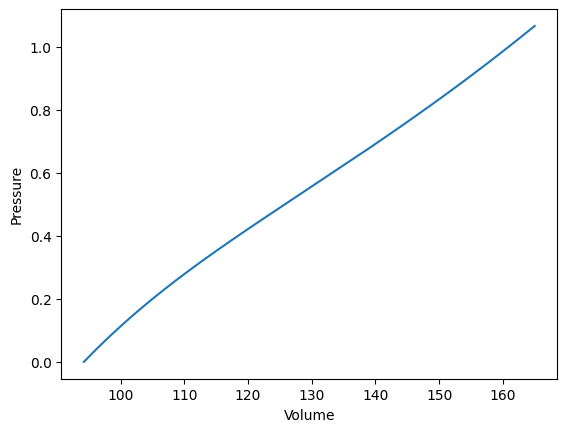

In [14]:
plt.plot(volumes, pressures)
plt.ylabel('Pressure')
plt.xlabel('Volume');

##### Plot current and reference configurations

Unfortunately this code no longer runs due to a compatiability issue with newer version of matplotlib, so I have commented it out

In [15]:
## Move mesh according to displacement
# u_int = interpolate(u, VectorFunctionSpace(mesh, "CG", 1))
# moved_mesh = Mesh(mesh)
# ALE.move(moved_mesh, u_int)

# plt.figure(figsize = (16,12))

# plot(moved_mesh, alpha=0.1, edgecolor='k', color='w')
# plot(mesh, color="r")

# ax = plt.gca()
# ax.view_init(elev=25, azim=-179)
# ax.set_axis_on()
# plt.show()

##### Print statistics relating to the magnitude of the displacements

In [17]:
displacement = u.compute_vertex_values().reshape(mesh.coordinates().shape, order='F')
displacement_norms = ((displacement**2).sum(-1)**.5)
L, H, W = mesh.coordinates().max(0) - mesh.coordinates().min(0) 

print(f'LV Dimensions : {L:.2f}cm*{H:.2f}cm*{W:.2f} cm')
print(f'Num Nodes : {mesh.coordinates().shape[0]}')
print(f"(a, b, af, bf): ({theta[0]}, {theta[1]} {theta[2]}, {theta[3]})")
print(f'Max  Disp. Norm: {displacement_norms.max():5f} cm')
print(f'Mean Disp. Norm: {displacement_norms.mean():5f} cm\n')
print(f'displacement[:5]: \n{displacement[:5]}')

LV Dimensions : 7.21cm*7.54cm*7.52 cm
Num Nodes : 1570
(a, b, af, bf): (0.18, 2.6 3.34, 2.73)
Max  Disp. Norm: 1.631097 cm
Mean Disp. Norm: 0.735666 cm

displacement[:5]: 
[[ 0.69778594  0.99489012 -1.05067016]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-0.22400938  0.27912593 -1.18242736]
 [-0.08551088  0.86693907 -0.56792364]]


##### Compute the total potential energy value for the computed solution function

In [18]:
Pi_vals = compute_Pi(u, theta, f0, True)
Pi, Pi_internal, Pi_external = [assemble(val) for val in Pi_vals]

In [19]:
print(f"Internal potential energy: {Pi_internal:2f}")
print(f"External potential energy: {Pi_external:2f}")
print(f"Total potential energy   : {Pi:2f}")

Internal potential energy: 52.147051
External potential energy: 95.890836
Total potential energy   : -43.743786


## Save Results

In [20]:
results_save_dir = "lvSaveDir"
import os
if not os.path.isdir(results_save_dir): os.makedirs(results_save_dir)
results_save_dir

'lvSaveDir'

In [21]:
np.save(f'{results_save_dir}/coords.npy', mesh.coordinates())
np.save(f'{results_save_dir}/elements.npy', mesh.cells())
np.save(f'{results_save_dir}/displacement.npy', displacement)
np.save(f'{results_save_dir}/theta.npy', theta)
np.save(f'{results_save_dir}/pe-value.npy', Pi)
np.save(f'{results_save_dir}/lv-volume.npy', volumes[-1])